In [1]:
%matplotlib inline

import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import MZKdV
import glob
import re

from IPython.display import HTML
from scipy import integrate
from scipy import stats
from matplotlib import animation

In [2]:
from MZKdV import *

In [5]:
def automatedROM(N,alpha,epsilon,timesteps,fitTime,tauTests,IC = np.sin,tol = 1e-12):
    
    endtime = timesteps[-1]
    
    M = 16
    unresolved = True
    print("Constructing reference exact solution...")
    
    try:
        fileList = glob.glob("u" + '[0-9]*' + "t" + str(int(endtime))+"e"+str(epsilon).replace('.','p')+".npy")
        myFile = fileList[0]
        uFull = np.load(myFile)
        
        fileList = glob.glob("t" + '[0-9]*' + "t" + str(int(endtime))+"e"+str(epsilon).replace('.','p')+".npy")
        myFile = fileList[0]
        tFull = np.load(myFile)
        
        print("Success! (it was already saved)\n")
        
        M = int(re.findall(r'\d+', fileList[0])[0])
    except:
        # find resolved simulation    
        while unresolved:
        
            M = 2*M
            print("\nCurrently testing M = "+str(M))
            
            fullParams = {
                'N': M,
                'M': int(3/2*M),
                'alpha': 1,
                'epsilon': epsilon,
                'tau': 1,
                'coeffs': None,
                'IC': IC,
                'endtime': endtime,
                'timesteps': timesteps
                }

            uSimFull = runSim(fullParams)
            uFull = uSimFull.y
            tFull = uSimFull.t
            energyCheck = getMass(uFull,int(M/2))
            
            print("Maximum mass deviation in first "+str(M/2)+" modes: "+str(max(abs(energyCheck - energyCheck[0]))))
            
            if max(abs(energyCheck - energyCheck[0])) < tol:
                print("Success!\n")
                unresolved = False
                np.save("u" + str(M) + "t" + str(int(endtime))+"e"+str(epsilon).replace('.','p')+".npy",uFull)
                np.save("t" + str(M) + "t" + str(int(endtime))+"e"+str(epsilon).replace('.','p')+".npy",tFull)
        
    uFit = uFull[:,tFull<=fitTime]
    tFit = tFull[tFull<=fitTime]
    np.save("u" + str(M) + "t" + str(int(fitTime))+"e"+str(epsilon).replace('.','p')+".npy",uFit)
    np.save("t" + str(M) + "t" + str(int(fitTime))+"e"+str(epsilon).replace('.','p')+".npy",tFit)
    
    # Find specific fitting window
    
    print("Finding coefficients for range of tau values...")
    coefficients,errors = renormalizeTau(fullM = M,
                                         endtime = fitTime,
                                         Nlist = np.array([N]),
                                         Mlist = np.array([N*3]),
                                         epsilon = epsilon,
                                         alpha = alpha,
                                         tauList = tauTests,
                                         timesteps = tFit,
                                         IC = IC)
    
    err2 = [fit["t2-model only"][0][0] for fit in errors]
    c2 = coefficients["t2-model only"][err2.index(min(err2))][0]
    
    err4 = [fit["t2- and t4-models"][0][0] for fit in errors]
    c4 = coefficients["t2- and t4-models"][err4.index(min(err4))][0]

    
    print("Coefficients found!\n")
    
    paramsMarkov = {
                'N': N,
                'M': int(3*N),
                'alpha': 1,
                'epsilon': epsilon,
                'tau': 0,
                'coeffs': None,
                'IC': IC,
                'endtime': endtime,
                'timesteps': timesteps
                }
    
    params2 = {
                'N': N,
                'M': int(3*N),
                'alpha': 1,
                'epsilon': epsilon,
                'tau': tauTests[err2.index(min(err2))],
                'coeffs': np.array([0,c2[0]]),
                'IC': IC,
                'endtime': endtime,
                'timesteps': timesteps
                }
    
    params4 = {
                'N': N,
                'M': int(3*N),
                'alpha': 1,
                'epsilon': epsilon,
                'tau': tauTests[err4.index(min(err4))],
                'coeffs': np.array([0,c4[0],0,c4[1]]),
                'IC': IC,
                'endtime': endtime,
                'timesteps': timesteps
                }
    
    print("Running Markov simulation...\n")
    simMarkov = runSim(paramsMarkov)
    
    print("Running second order simulation with tau = "+str(tauTests[err2.index(min(err2))])+"...\n")
    sim2 = runSim(params2)
    
    print("Running fourth order simulation with tau = "+str(tauTests[err4.index(min(err4))])+"...")
    sim4 = runSim(params4)
    
    return simMarkov,sim2,sim4,coefficients,errors

In [12]:
N = 20
alpha = 1
epsilon = 0.1
timesteps = np.arange(0,1000.1,0.1)
fitTime = 10
tauTests = np.arange(0,1.05,0.05)
simMarkov,sim2,sim4,coefficients,errors = automatedROM(N,alpha,epsilon,timesteps,fitTime,tauTests,IC = np.sin,tol = 1e-3)

Constructing reference exact solution...
Success! (it was already saved)

Finding coefficients for range of tau values...


/Users/jrprice/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/jrprice/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/jrprice/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Coefficients found!

Running Markov simulation...

Running second order simulation with tau = 1.0...

Running fourth order simulation with tau = 1.0...


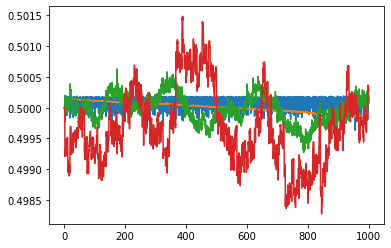

In [20]:
uExact = np.load("u64t1000e0p1.npy")
uMarkov = simMarkov.y
u2 = sim2.y
u4 = sim4.y
timesteps = sim2.t

fig,ax = plt.subplots()
ax.plot(timesteps,getMass(uExact[:,0:10001],20))
ax.plot(timesteps,getMass(uMarkov,20))
ax.plot(timesteps,getMass(u2,20))
ax.plot(timesteps,getMass(u4,20))

In [25]:
uExact = uExact[:,0:10001]

In [17]:
tExact[-3:]

array([1000.7, 1000.8, 1000.9])

IndexError: index 201 is out of bounds for axis 1 with size 201

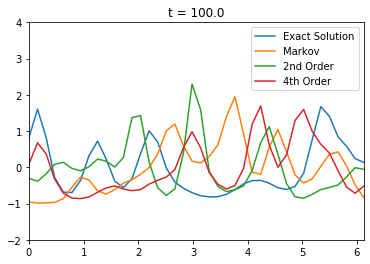

In [26]:
animate = makeAnimations([uExact[:,0::50],uMarkov[:,0::50],u2[:,0::50],u4[:,0::50]],timesteps[0::5],['Exact Solution','Markov','2nd Order','4th Order'])
HTML(animate.to_jshtml())

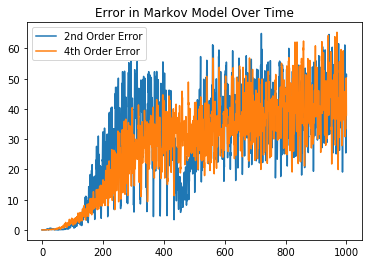

In [23]:
errList = findError([u2,u4],uExact[:,0:10001],timesteps)

plt.figure()
plt.plot(timesteps,errList[0])
plt.plot(timesteps,errList[1])
plt.title("Error in Markov Model Over Time")
plt.legend(["2nd Order Error","4th Order Error"])

In [31]:
timesteps[0::50].shape

(201,)

In [62]:
N = 20
alpha = 1
epsilonList = np.arange(0.05,0.105,0.005)
timesteps = np.arange(0,1001,0.1)
fitTimesteps = np.arange(0,10.1,0.1)
tauTests = 1
for epsilon in epsilonList:
    automatedROM(N,alpha,epsilon,timesteps,fitTimesteps,tauTests,IC = np.sin,tol = 1e-3)

Constructing reference exact solution...

Currently testing M = 8
Maximum mass deviation in first 4.0 modes: 0.4898843753094907

Currently testing M = 16
Maximum mass deviation in first 8.0 modes: 0.38981339009244914

Currently testing M = 32
Maximum mass deviation in first 16.0 modes: 0.1797668805909614

Currently testing M = 64
Maximum mass deviation in first 32.0 modes: 0.0030249948019889783

Currently testing M = 128
Maximum mass deviation in first 64.0 modes: 0.00012307120794396997
Success!

Finding coefficients for range of tau values...
Constructing reference exact solution...

Currently testing M = 8
Maximum mass deviation in first 4.0 modes: 0.47586404276135724

Currently testing M = 16
Maximum mass deviation in first 8.0 modes: 0.36500215995356067

Currently testing M = 32
Maximum mass deviation in first 16.0 modes: 0.13716172519988473

Currently testing M = 64
Maximum mass deviation in first 32.0 modes: 0.0013028651663403168

Currently testing M = 128
Maximum mass deviation 

In [60]:
np.arange(0.05,0.105,0.005)

array([0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 ,
       0.095, 0.1  ])

When the value of $\epsilon$ varies, the solutions change in noticeable ways. A natural question is this: do we need to allow the renormalization coefficients to depend on $\epsilon$? If so, in what way? To begin exploring this, we compare the fitted renormalization coefficients of the simulations presented above.

<IPython.core.display.Javascript object>


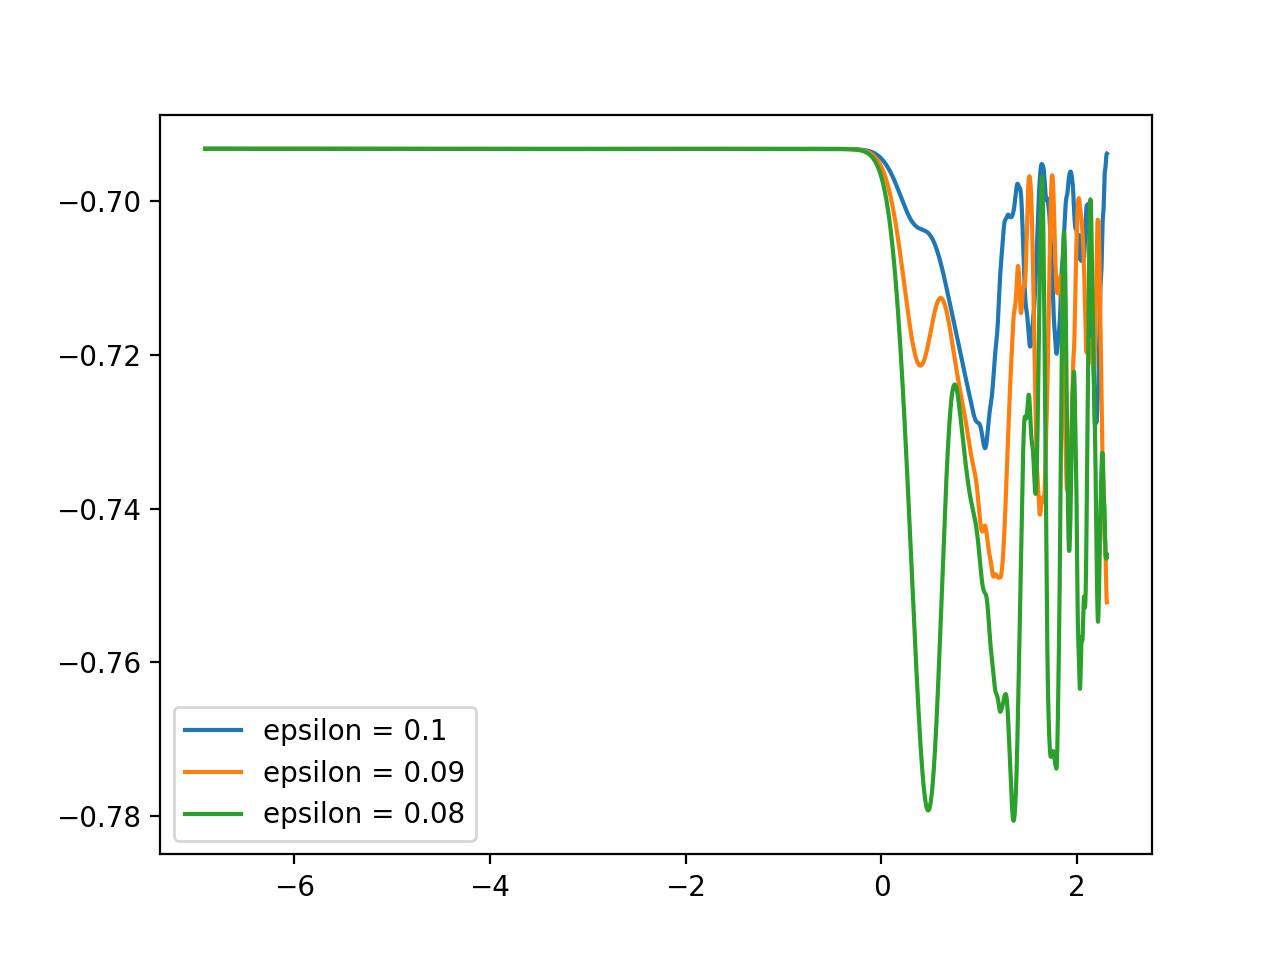

In [5]:
fullM = 256
endtime = 10
epsilonList = [0.1,0.09,0.08]
IC = np.sin
timesteps = np.arange(0,10.001,0.001)

for epsilon in epsilonList:

    try:
        uFull = np.load("u" + str(fullM) + "t" + str(endtime)+"e"+str(epsilon).replace('.','p')+".npy")
        tFull = np.load("t" + str(fullM) + "t" + str(endtime)+"e"+str(epsilon).replace('.','p')+".npy")
    except:
        fullParams = {
            'N': fullM,
            'M': int(3/2*fullM),
            'alpha': 1,
            'epsilon': epsilon,
            'tau': 1,
            'coeffs': None,
            'IC': IC,
            'endtime': endtime,
            'timesteps': timesteps
            }

        uSimFull = MZKdV.runSim(fullParams)
        uFull = uSimFull.y
        tFull = uSimFull.t
        np.save( "u" + str(fullM) + "t" + str(endtime)+"e"+str(epsilon).replace('.','p'),uFull)
        np.save( "t" + str(fullM) + "t" + str(endtime)+"e"+str(epsilon).replace('.','p'),tFull)
        
        
u1 = np.load("u256t10e0p1.npy")
t1 = np.load("t256t10e0p1.npy")
u09 = np.load("u256t10e0p09.npy")
t09 = np.load("t256t10e0p09.npy")
u08 = np.load("u256t10e0p08.npy")
t08 = np.load("t256t10e0p08.npy")

plt.figure()
plt.plot(np.log(t1[1:]),np.log(MZKdV.getMass(u1[:,1:],12)))
plt.plot(np.log(t08[1:]),np.log(MZKdV.getMass(u09[:,1:],12)))
plt.plot(np.log(t09[1:]),np.log(MZKdV.getMass(u08[:,1:],12)))
plt.legend(["epsilon = 0.1","epsilon = 0.09","epsilon = 0.08"])

<IPython.core.display.Javascript object>


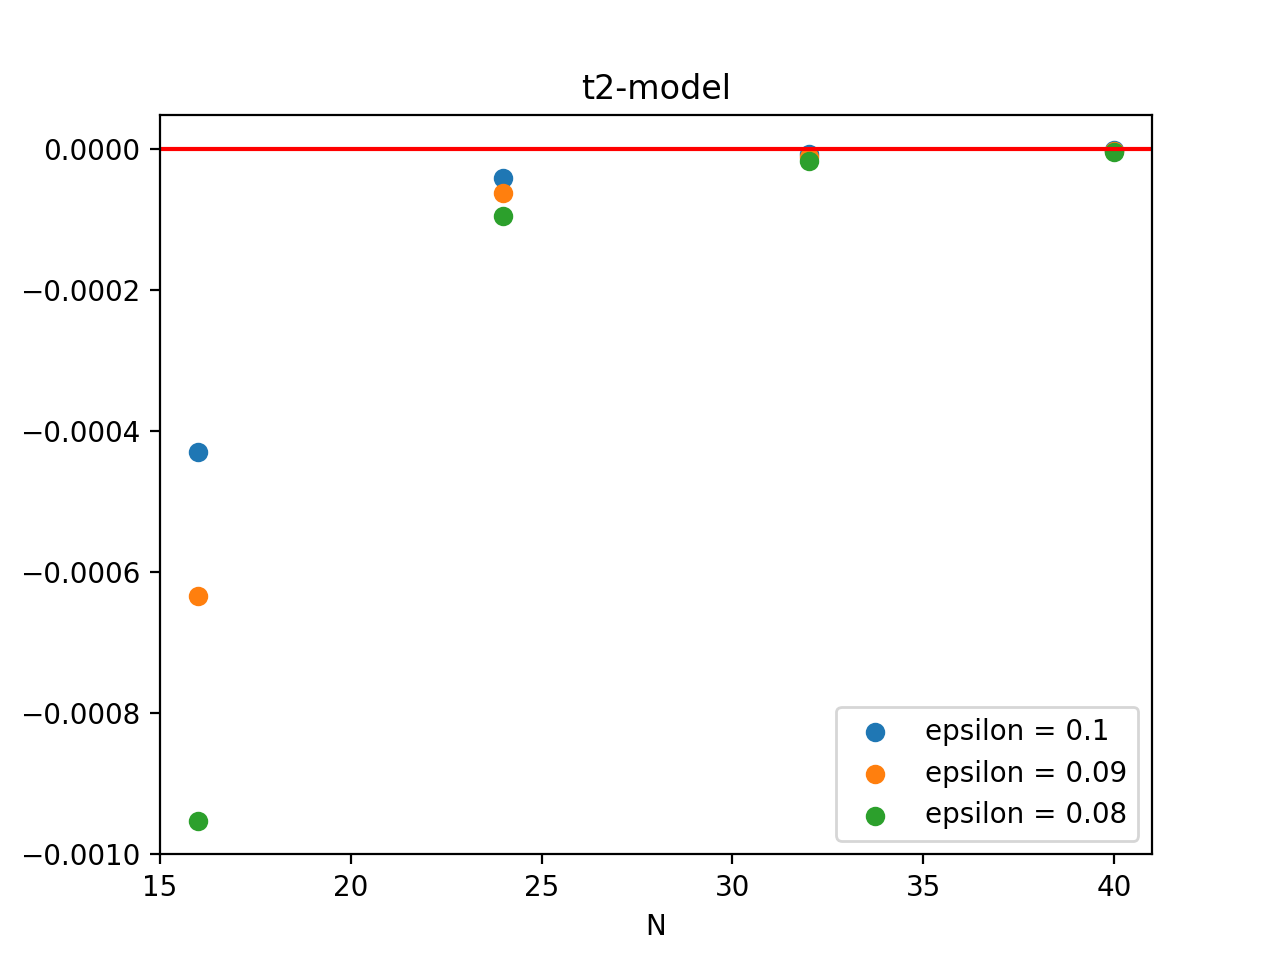

<IPython.core.display.Javascript object>


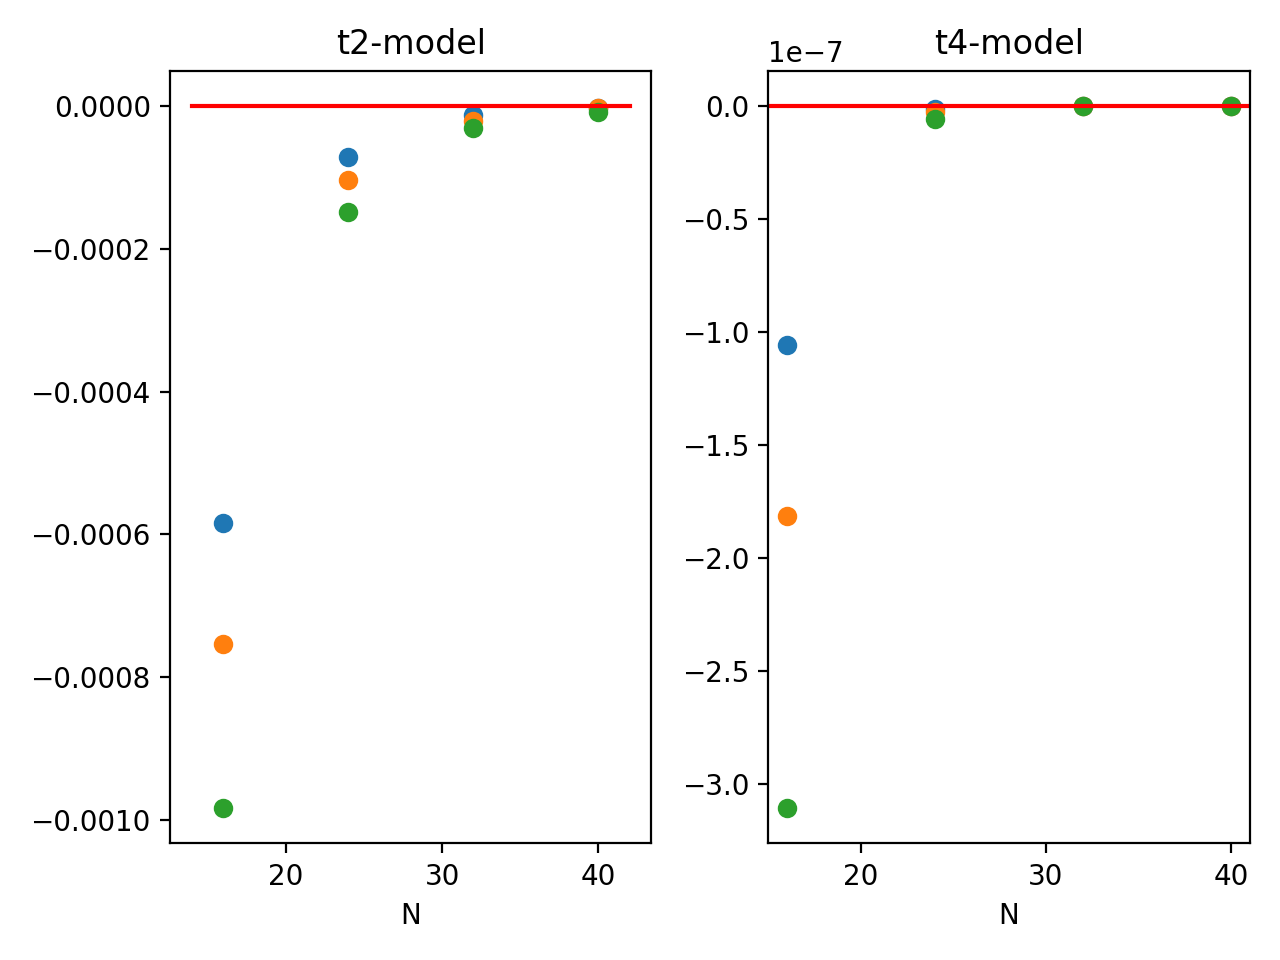

In [29]:
Nlist = np.arange(16,48,4)

renormResultse0p1 = MZKdV.renormalize(fullM = 256, 
                                endtime = 10, 
                                Nlist = Nlist, 
                                Mlist = 3*Nlist, 
                                epsilon = 0.1, 
                                alpha = 1, 
                                tau = 1, 
                                timesteps = timesteps, 
                                IC = np.sin, 
                                plots = False)
    

renormResultse0p09 = MZKdV.renormalize(fullM = 256, 
                                endtime = 10, 
                                Nlist = Nlist, 
                                Mlist = 3*Nlist, 
                                epsilon = 0.09, 
                                alpha = 1, 
                                tau = 1, 
                                timesteps = timesteps, 
                                IC = np.sin, 
                                plots = False)

renormResultse0p08 = MZKdV.renormalize(fullM = 256, 
                                endtime = 10, 
                                Nlist = Nlist, 
                                Mlist = 3*Nlist, 
                                epsilon = 0.08, 
                                alpha = 1, 
                                tau = 1, 
                                timesteps = timesteps, 
                                IC = np.sin, 
                                plots = False)


Nlist2 = np.arange(Nlist[0]-2,Nlist[-1]+4,2)

p5 = plt.figure()
plt.scatter(Nlist,renormResultse0p1[4])
plt.scatter(Nlist,renormResultse0p09[4])
plt.scatter(Nlist,renormResultse0p08[4])
plt.legend(["epsilon = "+str(i) for i in epsilonList])
plt.plot(Nlist2,Nlist2*0,"red")
plt.xlim(Nlist[0]-1,Nlist[-1]+1)
plt.title("t2-model")
plt.xlabel("N")


p6,a6 = plt.subplots(1,2)
a6[0].scatter(Nlist,renormResultse0p1[5][:,0])
a6[0].scatter(Nlist,renormResultse0p09[5][:,0])
a6[0].scatter(Nlist,renormResultse0p08[5][:,0])
a6[0].plot(Nlist2,Nlist2*0,"red")
plt.xlim(Nlist[0]-1,Nlist[-1]+1)
a6[0].set_title("t2-model")
a6[0].set_xlabel("N")

a6[1].scatter(Nlist,renormResultse0p1[5][:,1])
a6[1].scatter(Nlist,renormResultse0p09[5][:,1])
a6[1].scatter(Nlist,renormResultse0p08[5][:,1])
a6[1].plot(Nlist2,Nlist2*0,"red")
plt.xlim(Nlist[0]-1,Nlist[-1]+1)
a6[1].set_title("t4-model")
a6[1].set_xlabel("N")

plt.tight_layout()

We observe that the renormalization coefficients appear to depend on $\epsilon$ just as they depended on $N$. In fact, there appears to be another potential power law relationship. To formalize this result, we will find the optimal renormalization coefficients for a range of $N$ values and $\epsilon$ values. Because there appear to be power law relationships for both, we will also find the best fit lines for those relationships. This means our renormalization coefficients take the form $$c_i(N,\epsilon) = -\alpha_i N^{\beta_i}\epsilon^{\gamma_i}.$$The function below finds these coefficients, the scaling laws, and plots them.

<IPython.core.display.Javascript object>


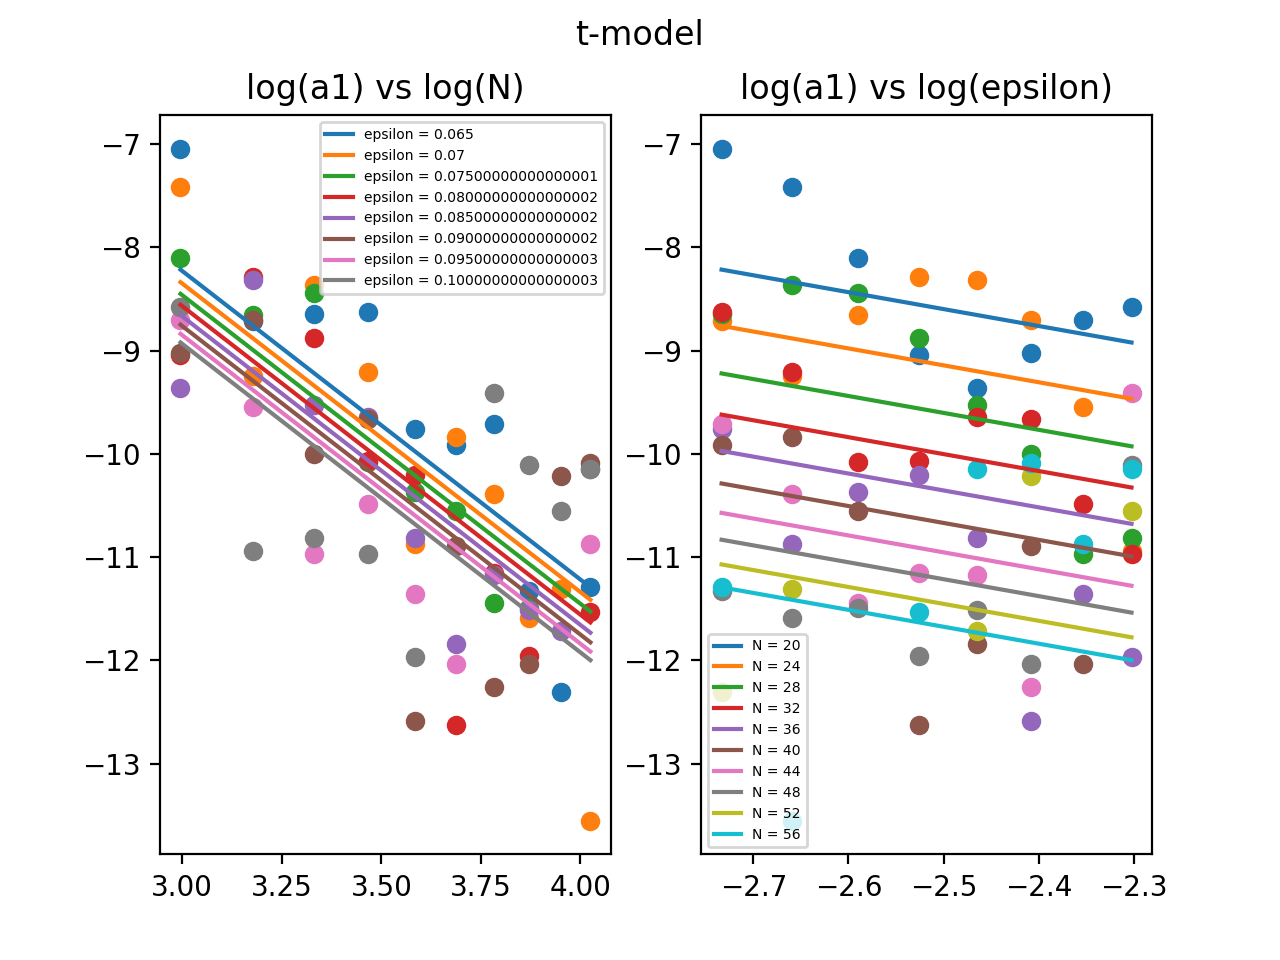

<IPython.core.display.Javascript object>


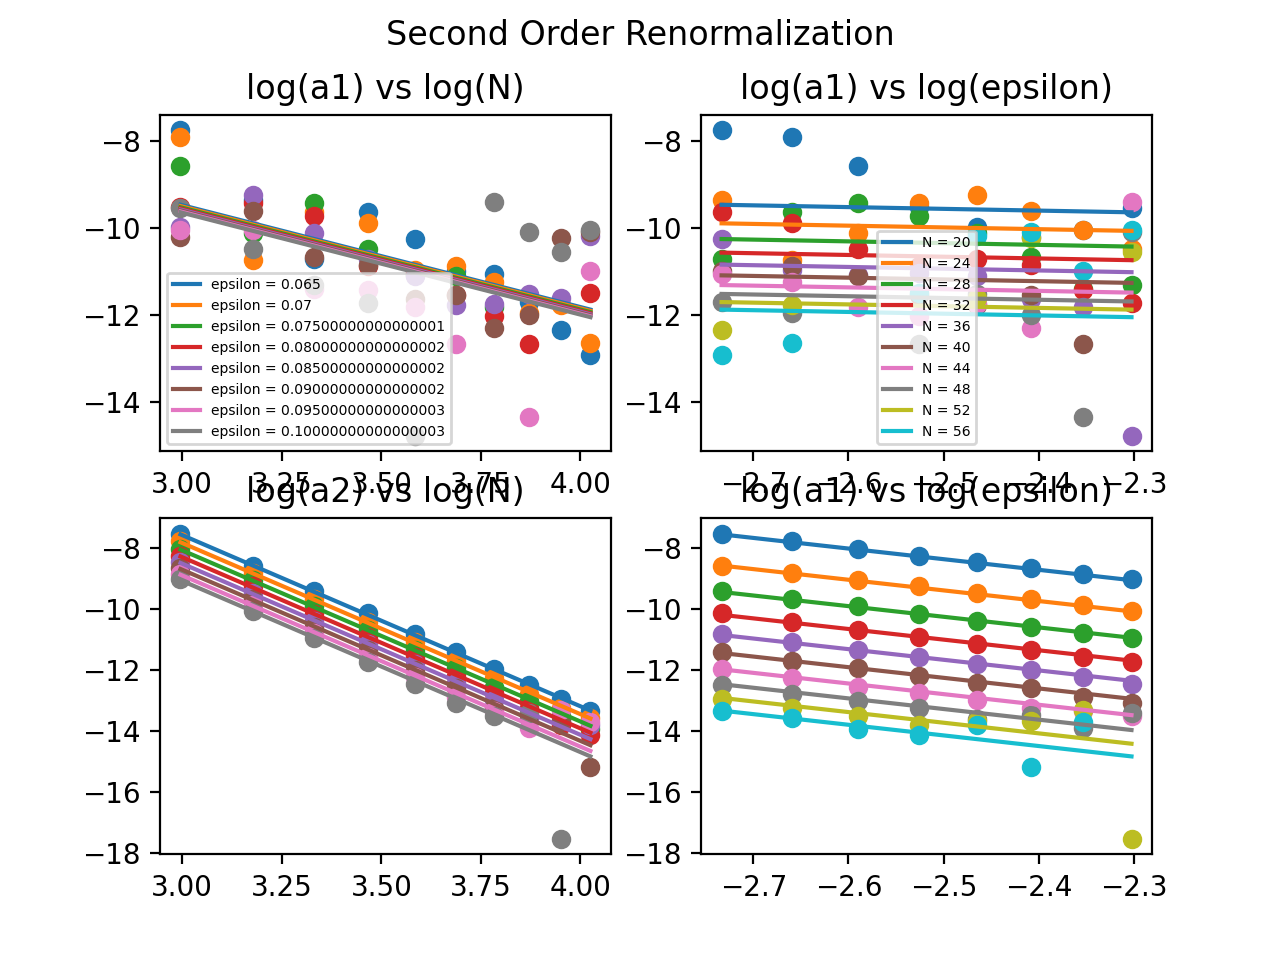

<IPython.core.display.Javascript object>


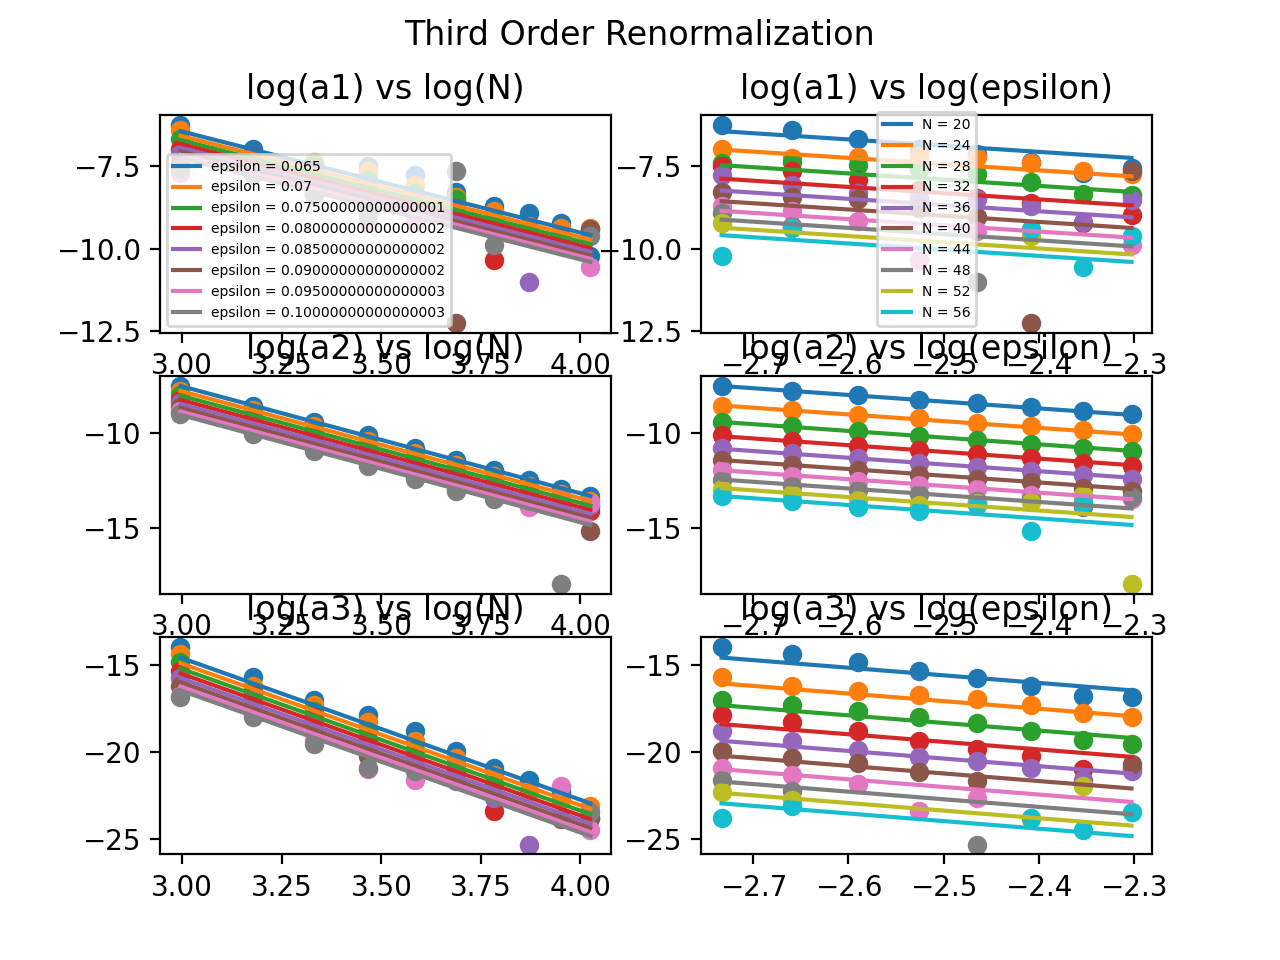

<IPython.core.display.Javascript object>


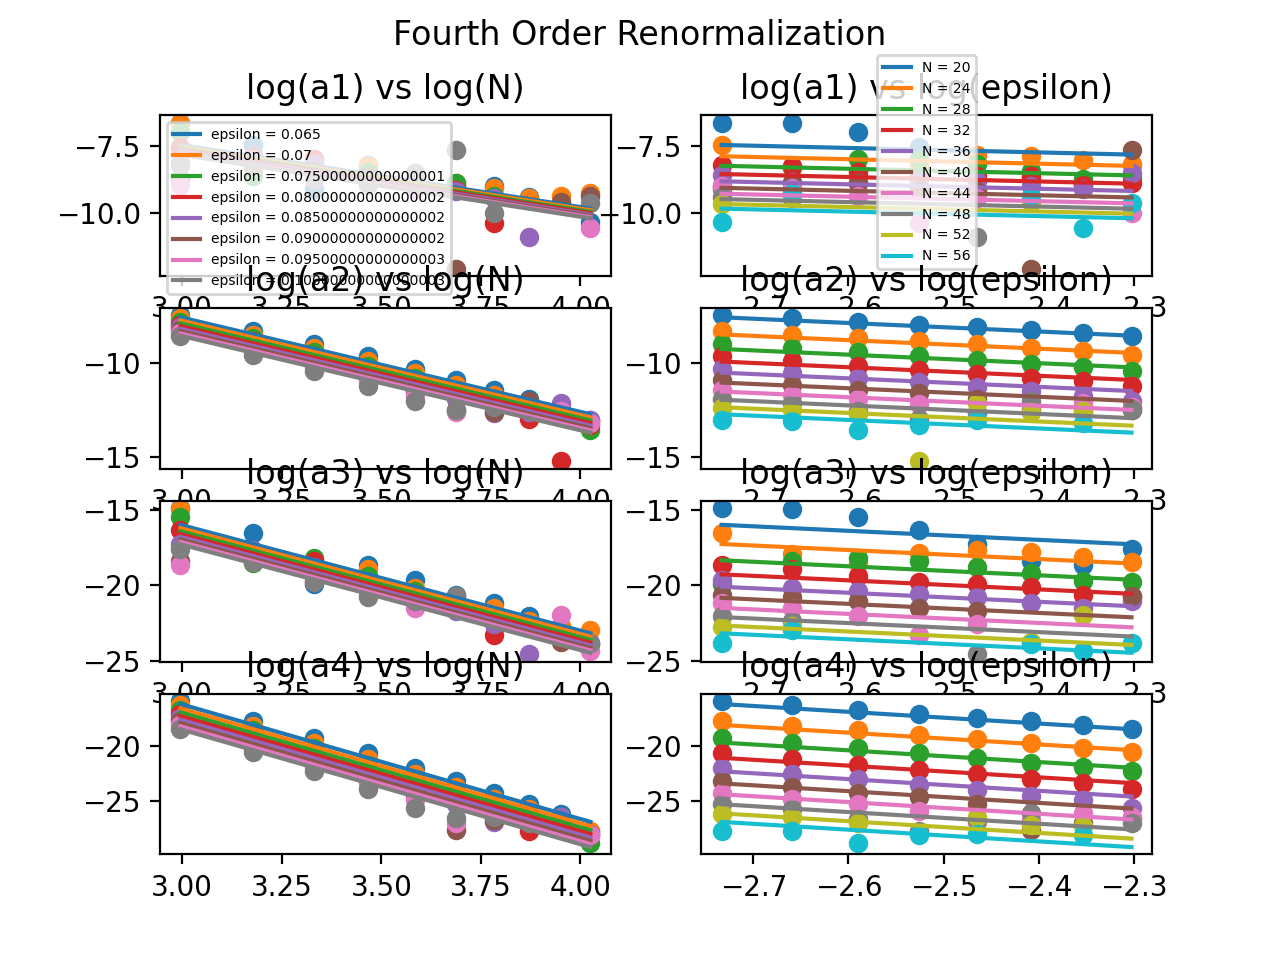

<IPython.core.display.Javascript object>


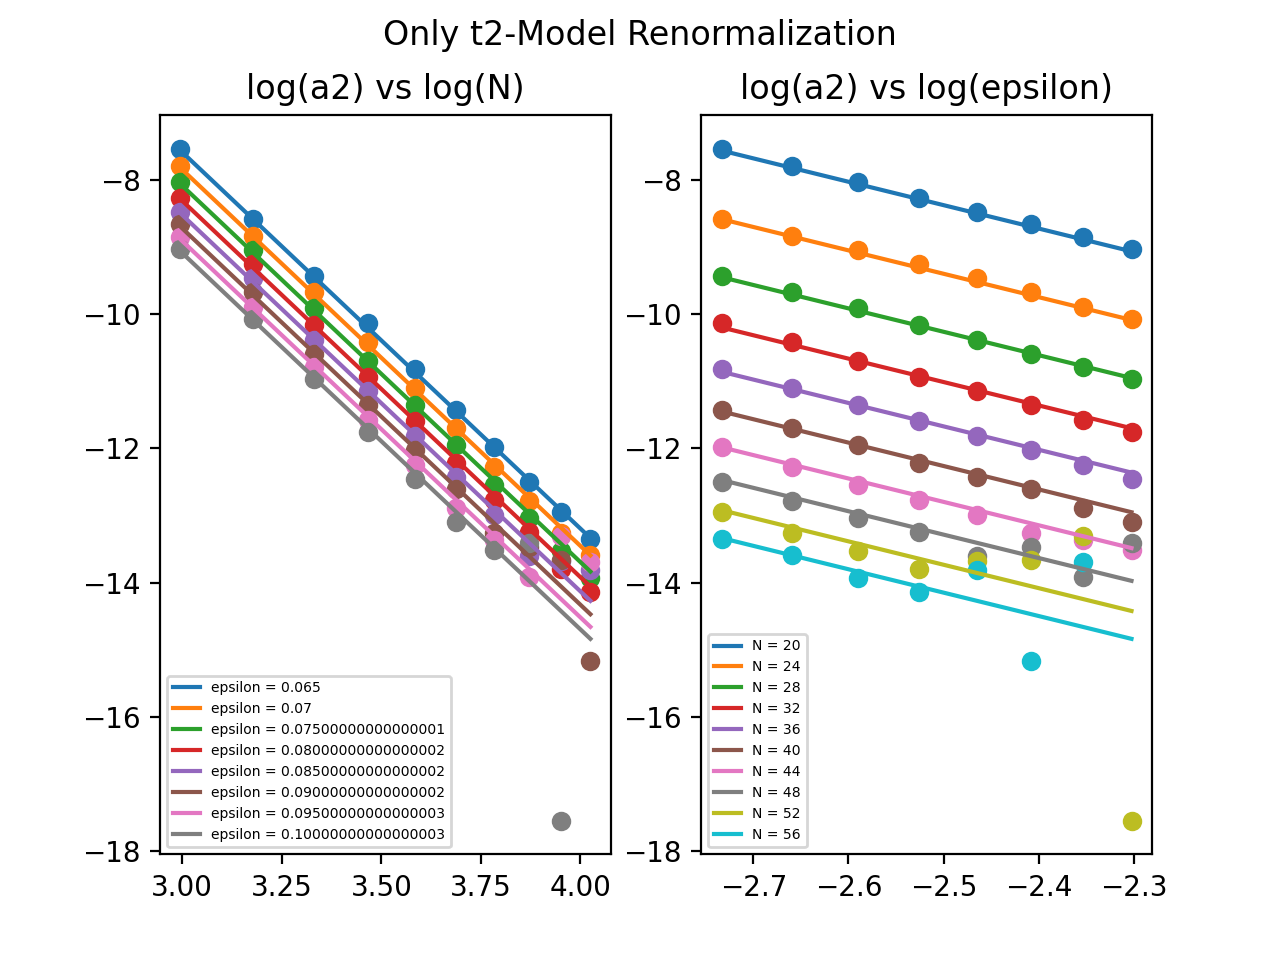

<IPython.core.display.Javascript object>


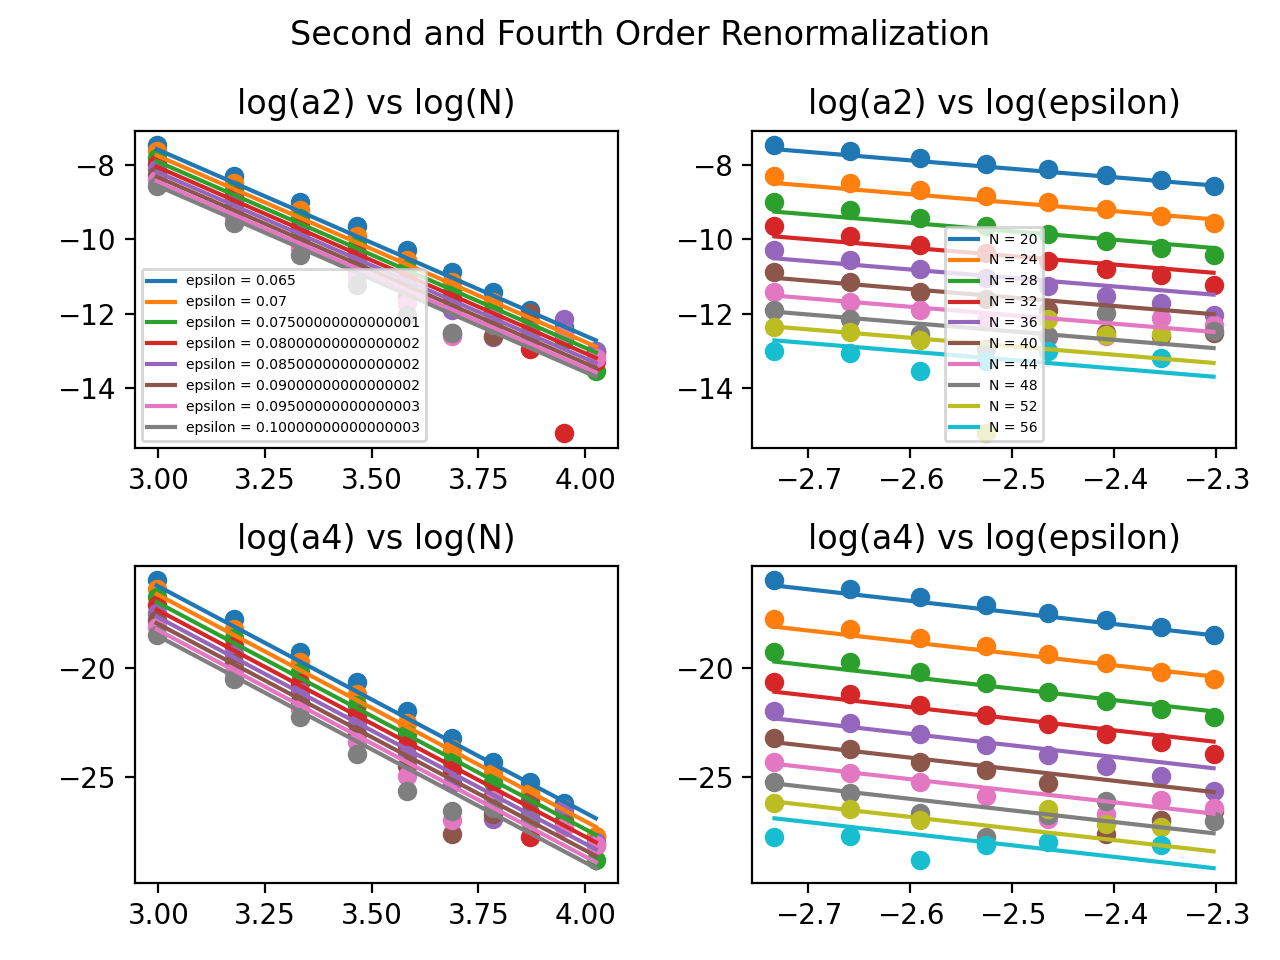

/Volumes/HomeSSD/Dropbox/Research/Software/Git/Renormalized_MZ_Python/KdV/MZKdV.py:1234: RuntimeWarning: invalid value encountered in log
  ax1[0].scatter(np.log(Nlist),np.log(-c1[:,0,i]))
/Volumes/HomeSSD/Dropbox/Research/Software/Git/Renormalized_MZ_Python/KdV/MZKdV.py:1237: RuntimeWarning: invalid value encountered in log
  ax2[0,0].scatter(np.log(Nlist),np.log(-c2[:,0,i]))
/Volumes/HomeSSD/Dropbox/Research/Software/Git/Renormalized_MZ_Python/KdV/MZKdV.py:1241: RuntimeWarning: invalid value encountered in log
  ax3[0,0].scatter(np.log(Nlist),np.log(-c3[:,0,i]))
/Volumes/HomeSSD/Dropbox/Research/Software/Git/Renormalized_MZ_Python/KdV/MZKdV.py:1243: RuntimeWarning: invalid value encountered in log
  ax3[2,0].scatter(np.log(Nlist),np.log(-c3[:,2,i]))
/Volumes/HomeSSD/Dropbox/Research/Software/Git/Renormalized_MZ_Python/KdV/MZKdV.py:1246: RuntimeWarning: invalid value encountered in log
  ax4[0,0].scatter(np.log(Nlist),np.log(-c4[:,0,i]))
/Volumes/HomeSSD/Dropbox/Research/Software/Git/

/Volumes/HomeSSD/Dropbox/Research/Software/Git/Renormalized_MZ_Python/KdV/MZKdV.py:1302: RuntimeWarning: invalid value encountered in log
  ax1[1].scatter(np.log(epsilonList),np.log(-c1[j,0,:]))
/Volumes/HomeSSD/Dropbox/Research/Software/Git/Renormalized_MZ_Python/KdV/MZKdV.py:1305: RuntimeWarning: invalid value encountered in log
  ax2[0,1].scatter(np.log(epsilonList),np.log(-c2[j,0,:]))
/Volumes/HomeSSD/Dropbox/Research/Software/Git/Renormalized_MZ_Python/KdV/MZKdV.py:1309: RuntimeWarning: invalid value encountered in log
  ax3[0,1].scatter(np.log(epsilonList),np.log(-c3[j,0,:]))
/Volumes/HomeSSD/Dropbox/Research/Software/Git/Renormalized_MZ_Python/KdV/MZKdV.py:1311: RuntimeWarning: invalid value encountered in log
  ax3[2,1].scatter(np.log(epsilonList),np.log(-c3[j,2,:]))
/Volumes/HomeSSD/Dropbox/Research/Software/Git/Renormalized_MZ_Python/KdV/MZKdV.py:1314: RuntimeWarning: invalid value encountered in log
  ax4[0,1].scatter(np.log(epsilonList),np.log(-c4[j,0,:]))
/Volumes/HomeSSD/

({'t-model': array([[[-8.70457826e-04, -6.02638032e-04, -3.02044715e-04,
           -1.17859186e-04, -8.59910653e-05, -1.20041718e-04,
           -1.65292877e-04, -1.88980299e-04]],
  
         [[-1.64286321e-04, -9.68744190e-05, -1.74043602e-04,
           -2.51450901e-04, -2.43492726e-04, -1.65647384e-04,
           -7.15765595e-05, -1.77908362e-05]],
  
         [[-1.76411172e-04, -2.32253076e-04, -2.16040220e-04,
           -1.39556561e-04, -7.26848461e-05, -4.54012880e-05,
           -1.71662383e-05, -2.00950500e-05]],
  
         [[-1.79804279e-04, -1.00239976e-04, -4.21684453e-05,
           -4.22116610e-05, -6.48070515e-05, -6.38650633e-05,
           -2.80509953e-05, -1.72783517e-05]],
  
         [[-5.75719826e-05, -1.90143901e-05, -3.13358244e-05,
           -3.70645376e-05, -2.00707070e-05, -3.42336834e-06,
           -1.17053520e-05, -6.35226322e-06]],
  
         [[-4.92505047e-05, -5.36730642e-05, -2.61272734e-05,
           -3.29546709e-06, -7.19576975e-06, -1.85295941e

In [4]:
fullM = 256
endtime = 10
epsilonList = [0.1,0.09,0.08]
Nlist = np.arange(20,60,4)
IC = np.sin
timesteps = np.arange(0,10.001,0.001)
epsilonList = np.arange(0.065,0.1,0.005)

MZKdV.scalingLaws(fullM = fullM,
            endtime = endtime,
            Nlist = Nlist,
            Mlist = 3*Nlist,
            epsilonList = epsilonList,
            alpha = 1,
            tau = 1,
            timesteps = timesteps,
            IC = np.sin,
            plots = True)

These results truly are quite remarkable. We see that the value of the coefficients needed to optimize the complete memory approximation have a strict scaling law dependence both on the resolution of the model ($N$) and the amount of dispersion in the system ($\epsilon$). If you recall the functional forms of the terms in the complete memory approximation, this is flabbergasting. They are absolute messes of convolutions nested in convolutions in unpredictable and wild ways. And yet...*and yet*, there is a mysterious structure to the coefficients needed to render those systems stable. And what's more, the resulting renormalized models are *extremely accurate*! We'll investigate that once we finish exploring this renormalization process a bit more. Next, let's find out just how robust these coefficients are. If they do tap into mysterious, wonderful structure, then we would hope they are stable to different methods of approximating them.

In [39]:
fullM = 128
epsilon = 0.1
endtime = 50
width = 30
alpha = 1
tauList = np.arange(0,1+0.01,0.01)
Nlist = np.array([12])
Mlist = 3*Nlist
timesteps = np.arange(0,endtime+0.1,0.1)

out = MZKdV.renormalizeTau(fullM = fullM,endtime = endtime,Nlist = Nlist, Mlist = Mlist, epsilon = epsilon, alpha = alpha, tauList = tauList, timesteps = timesteps)
fig,ax = plt.subplots()
ax.plot(tauList,[i["t-model"][0][0] for i in out[1]])
ax.plot(tauList,[i["t2-model"][0][0] for i in out[1]],linestyle = "-.",linewidth = 3)
ax.plot(tauList,[i["t3-model"][0][0] for i in out[1]])
ax.plot(tauList,[i["t4-model"][0][0] for i in out[1]],linestyle = "-.",linewidth = 3)
ax.plot(tauList,[i["t2-model only"][0][0] for i in out[1]])
ax.plot(tauList,[i["t2- and t4-models"][0][0] for i in out[1]])
ax.legend(["t-model error","t2-model error","t3-model error","t4-model error","t2-model alone error","t2- and t4-models error"])
ax.title("N = "+str(Nlist[0]))

/Users/jake/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/jake/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/jake/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


KeyboardInterrupt: 

The final task in studying these coefficients is to understand the impact of the time scaling $\tau$. Recall that the coefficients have the form $c_i = -\alpha_i N^{\beta_i}\epsilon^{\gamma_i}t^{-i\tau}$ and that we have seen that $\tau = 1$ yields accurate, stable simulations while $\tau = 0$ yields unstable simulations. We now would like to see if one could have guessed that $\tau = 1$ is the best choice. First, let's consider the range of $\tau$ values we would like to consider. Recall that when we multiple our renormalization coefficient through, the time dependence for term $i$ is $t^{i(1-\tau)}$. If $\tau>1$, then at time zero we will raise 0 to a negative power and the model is not well defined. All other values of $\tau$ seem somewhat reasonable, though a value of $\tau<0$ would be odd, as it would imply a stronger time dependence than the original Taylor series required.

We are now going to use the err term that is output by our renormalize function. When it fits renormalization coefficients, it saves the least squares error of the best fit. So if this number is small, it means that the dynamics were very well captured by renormalization coefficients with that time dependence. We will then fit renormalization coefficients for a range of $\tau$ values and see if different $\tau$ values give different strengths of fit.

<IPython.core.display.Javascript object>


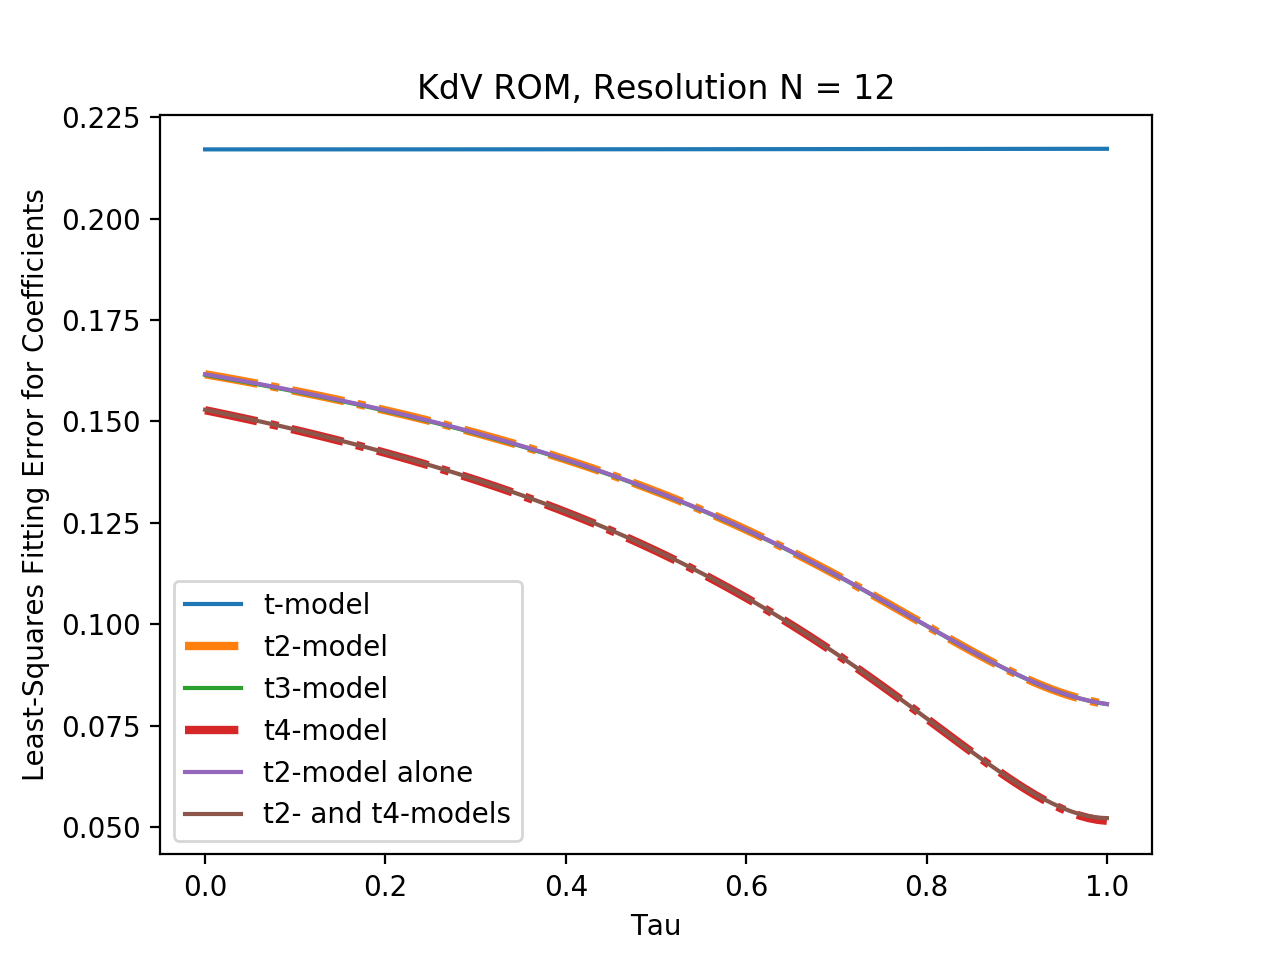

Text(0, 0.5, 'Least-Squares Fitting Error for Coefficients')

In [56]:
fullM = 128
epsilon = 0.1
endtime = 50
width = 30
alpha = 1
tauList = np.arange(-0.25,1+0.01,0.01)
Nlist = np.array([12])
Mlist = 3*Nlist
timesteps = np.arange(0,endtime+0.1,0.1)

fig,ax = plt.subplots()
ax.plot(tauList,[i["t-model"][0][0] for i in out[1]])
ax.plot(tauList,[i["t2-model"][0][0] for i in out[1]],linestyle = "-.",linewidth = 3)
ax.plot(tauList,[i["t3-model"][0][0] for i in out[1]])
ax.plot(tauList,[i["t4-model"][0][0] for i in out[1]],linestyle = "-.",linewidth = 3)
ax.plot(tauList,[i["t2-model only"][0][0] for i in out[1]])
ax.plot(tauList,[i["t2- and t4-models"][0][0] for i in out[1]])
ax.legend(["t-model","t2-model","t3-model","t4-model","t2-model alone","t2- and t4-models"])
ax.set_title("KdV ROM, Resolution N = "+str(Nlist[0])+", epsilon = "+str(epsilon))
ax.set_xlabel("Tau")
ax.set_ylabel("Least-Squares Fitting Error for Coefficients")

What a remarkable plot! We see a great number of things. First, the t-model renormalization fits just as well no matter the value of $\tau$. This makes sense, because for that model $\tau$ is just a linear scaling, so when $\tau$ changes, the coefficients can also change linearly to give exactly the same goodness. We see that the second order model has a minimal error at $\tau = 1$. Surprisingly, we also see that the error in the fit is almost exactly the same whether you include the $t$-model term or not. That is very strong evidence that the t-model term should be excluded. The same pattern is seen in the fourth order model and the model that excludes the first and third terms. This provides very convincing evidence that 1) $\tau = 1$ is the right choice for this equation and 2) it is appropriate to omit the odd terms when constructing a reduced order model.

In [50]:
"N = " + str(Nlist[0])

'N = 12'

In [7]:
c1 = out[0]['t-model']
c2 = out[0]['t2-model']
c3 = out[0]['t3-model']
c4 = out[0]['t4-model']
c2only = out[0]['t2-model only']
c24only = out[0]['t2- and t4-models']
fitLines = out[1]

In [13]:
Nlist

array([20, 28, 36])

In [30]:
epsilonList
#Nlist

numEps = len(epsilonList)
numN = len(Nlist)

epsilonTile = np.tile(epsilonList,(numN,1))
Ntile = np.transpose(np.tile(Nlist,(numEps,1)))

#t2.shape


#LSMatrix = (np.array([[numEps*numN,np.sum(np.log(Nlist))*numEps,np.sum(np.log(epsilonList))*numN],
#                             [np.sum(np.log(Nlist))*numEps,np.sum(np.log(Nlist)**2)*numEps,np.sum(np.log(Nlist)*np.log(epsilonList))],
#                             [np.sum(R3Energy*R1Energy),np.sum(R3Energy*R2Energy),np.sum(R3Energy*R3Energy)]]))

<IPython.core.display.Javascript object>


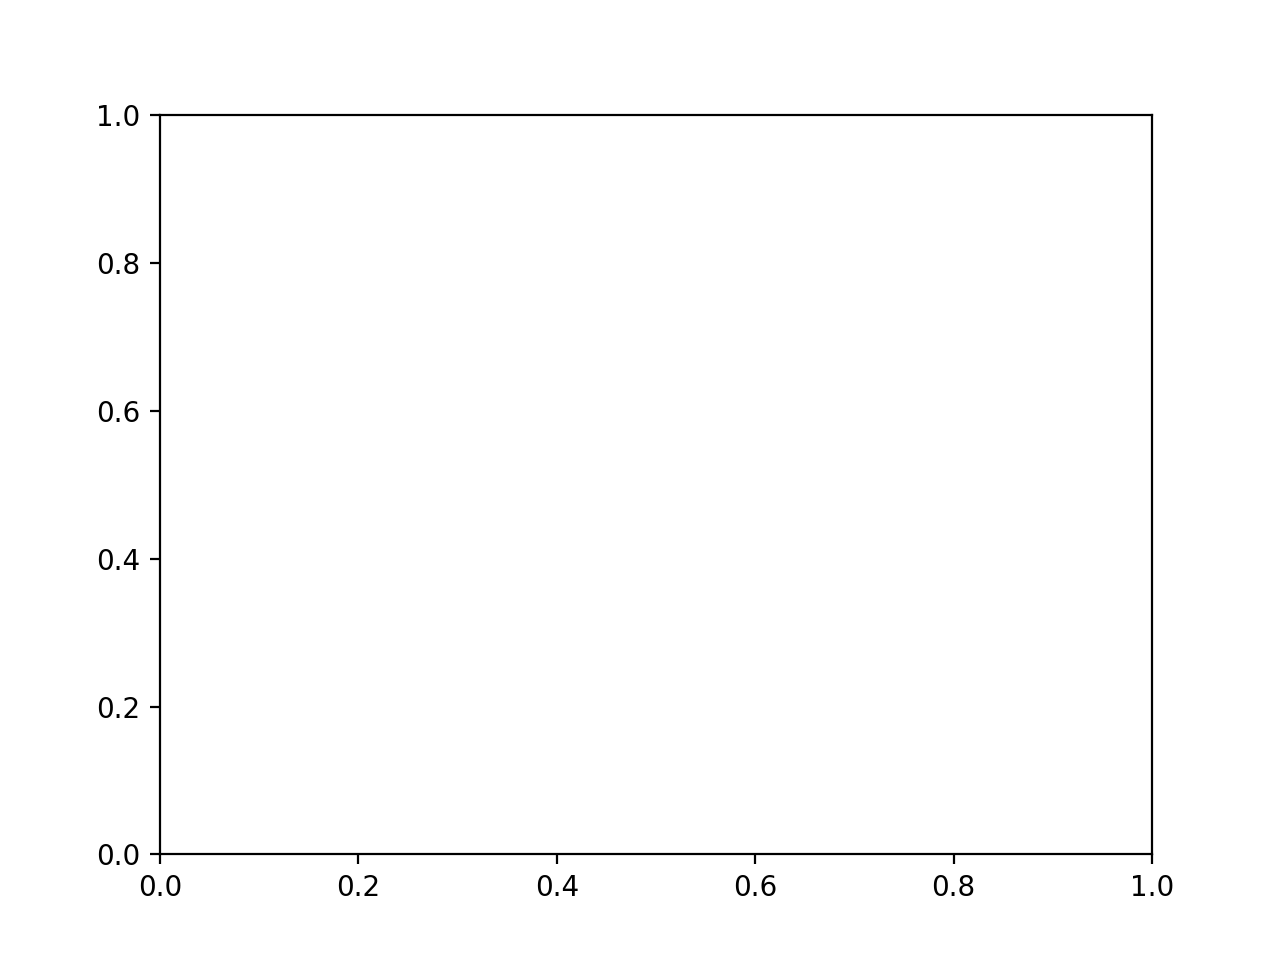

IndexError: index 11 is out of bounds for axis 0 with size 11

In [38]:
c1 = np.zeros((len(Nlist),1,len(epsilonList)))
    c2 = np.zeros((len(Nlist),2,len(epsilonList)))
    c3 = np.zeros((len(Nlist),3,len(epsilonList)))
    c4 = np.zeros((len(Nlist),4,len(epsilonList)))
    c2only = np.zeros((len(Nlist),1,len(epsilonList)))
    c24only = np.zeros((len(Nlist),2,len(epsilonList)))




numEps = len(epsilonList)
numN = len(Nlist)
epsilonTile = np.tile(epsilonList,(numN,1))
Ntile = np.transpose(np.tile(Nlist,(numEps,1)))
coeffArray = np.zeros((numN,numEps))
coeffArray[:] = t2[:,1,:]
oneArray = np.ones((numN,numEps))

LSMatrix = (np.array([[np.sum(oneArray),np.sum(np.log(Ntile)),np.sum(np.log(epsilonTile))],
                     [np.sum(np.log(Ntile)),np.sum(np.log(Ntile)**2),np.sum(np.log(Ntile)*np.log(epsilonTile))],
                     [np.sum(np.log(epsilonTile)),np.sum(np.log(Ntile)*np.log(epsilonTile)),np.sum(np.log(epsilonTile)**2)]])
           )

LSb = np.array([np.sum(np.log(-coeffArray)),np.sum(np.log(-coeffArray)*np.log(Ntile)),np.sum(np.log(-coeffArray)*np.log(epsilonTile))])

sol = np.linalg.solve(LSMatrix,LSb)
sol[0] = np.exp(sol[0])
sol

#p,a = plt.subplots(2,2)
#a[0,0].scatter(np.log(Nlist),np.log(-t2[:,1,0]))
#a[0,0].plot(np.log(Nlist),np.log(sol[0])+sol[1]*np.log(Nlist)+sol[2]*np.log(epsilonList[0]))
#a[0,1].scatter(np.log(Nlist),np.log(-t2[:,1,1]))
#a[0,1].plot(np.log(Nlist),np.log(sol[0])+sol[1]*np.log(Nlist)+sol[2]*np.log(epsilonList[1]))
#a[1,0].scatter(np.log(Nlist),np.log(-t2[:,1,2]))
#a[1,0].plot(np.log(Nlist),np.log(sol[0])+sol[1]*np.log(Nlist)+sol[2]*np.log(epsilonList[2]))
#a[1,1].scatter(np.log(Nlist),np.log(-t2[:,1,3]))
#a[1,1].plot(np.log(Nlist),np.log(sol[0])+sol[1]*np.log(Nlist)+sol[2]*np.log(epsilonList[3]))

i = 11
p2,a2 = plt.subplots(1,1)
a2.scatter(np.log(epsilonList),np.log(-t2[i,1,:]))
a2.plot(np.log(epsilonList),np.log(sol[0])+sol[1]*np.log(Nlist[i])+sol[2]*np.log(epsilonList))


In [25]:
t2.shape

(11, 2, 4)

In [44]:
Ntile

array([[32, 32, 32, 32],
       [34, 34, 34, 34],
       [36, 36, 36, 36],
       [38, 38, 38, 38],
       [40, 40, 40, 40],
       [42, 42, 42, 42],
       [44, 44, 44, 44],
       [46, 46, 46, 46],
       [48, 48, 48, 48],
       [50, 50, 50, 50],
       [52, 52, 52, 52],
       [54, 54, 54, 54],
       [56, 56, 56, 56],
       [58, 58, 58, 58],
       [60, 60, 60, 60]])

In [101]:
out[3][:,3,4]

array([-2.38235311e-10, -1.21812239e-10, -6.25053340e-11, -3.32439851e-11,
       -1.97847960e-11, -1.03915923e-11, -5.83331366e-12, -2.43898351e-12,
       -9.47329887e-13,  8.95219907e-13,  6.95489061e-13,  4.44322893e-13,
       -6.46955387e-13, -9.04640111e-13, -8.90079780e-13])

In [2]:
M = 16
epsilon = 0.1
endtime = 2
Nlist = np.array([4,6,8])

MZKdV.renormalize(M,endtime,Nlist,epsilon)

(0, 0)

<IPython.core.display.Javascript object>


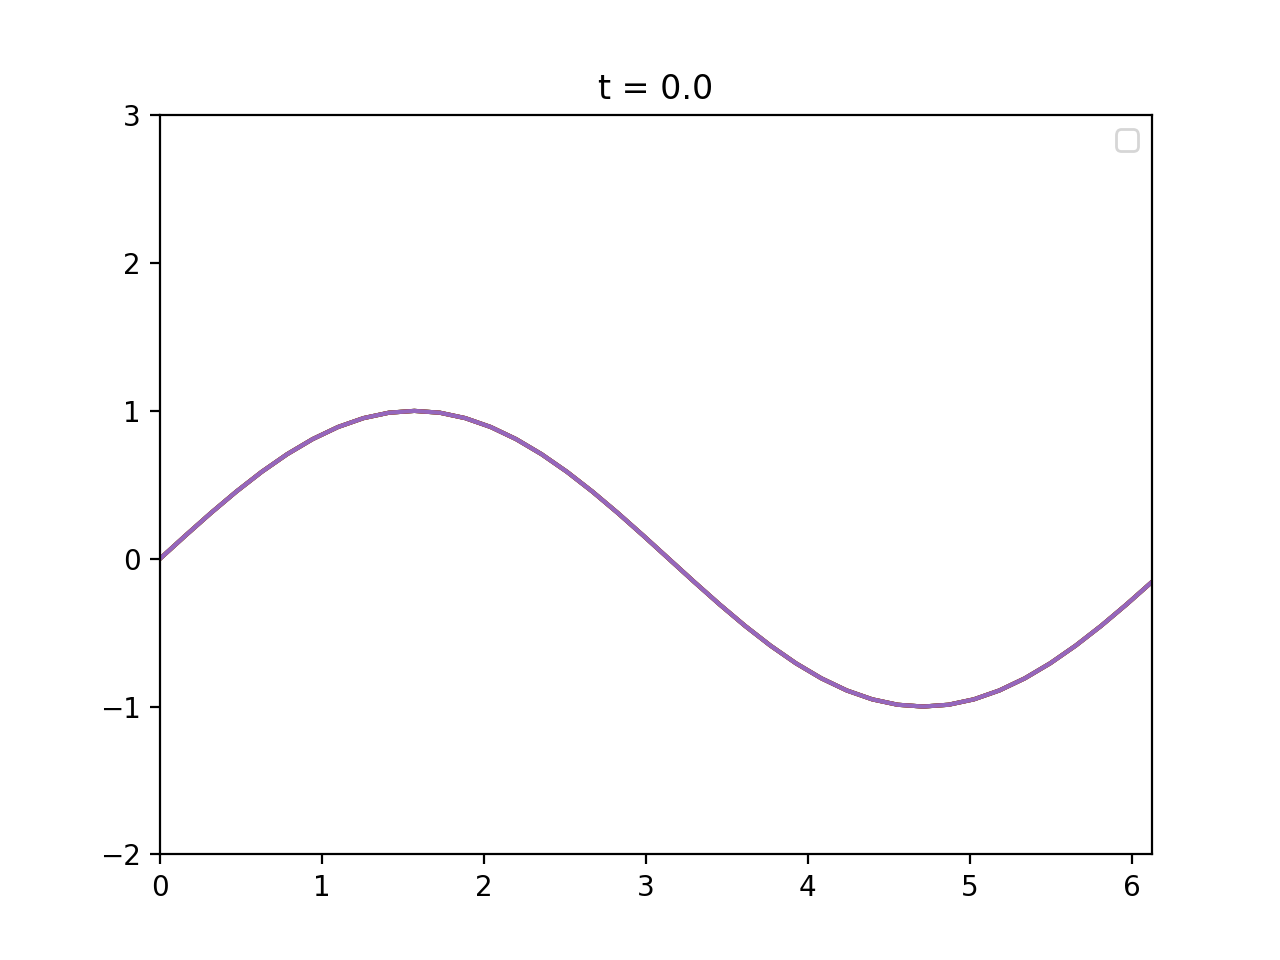

In [8]:
MZKdV.makeAnimations(simList,t,["a","b","c","d","e"])

In [37]:
anim

<IPython.core.display.Javascript object>


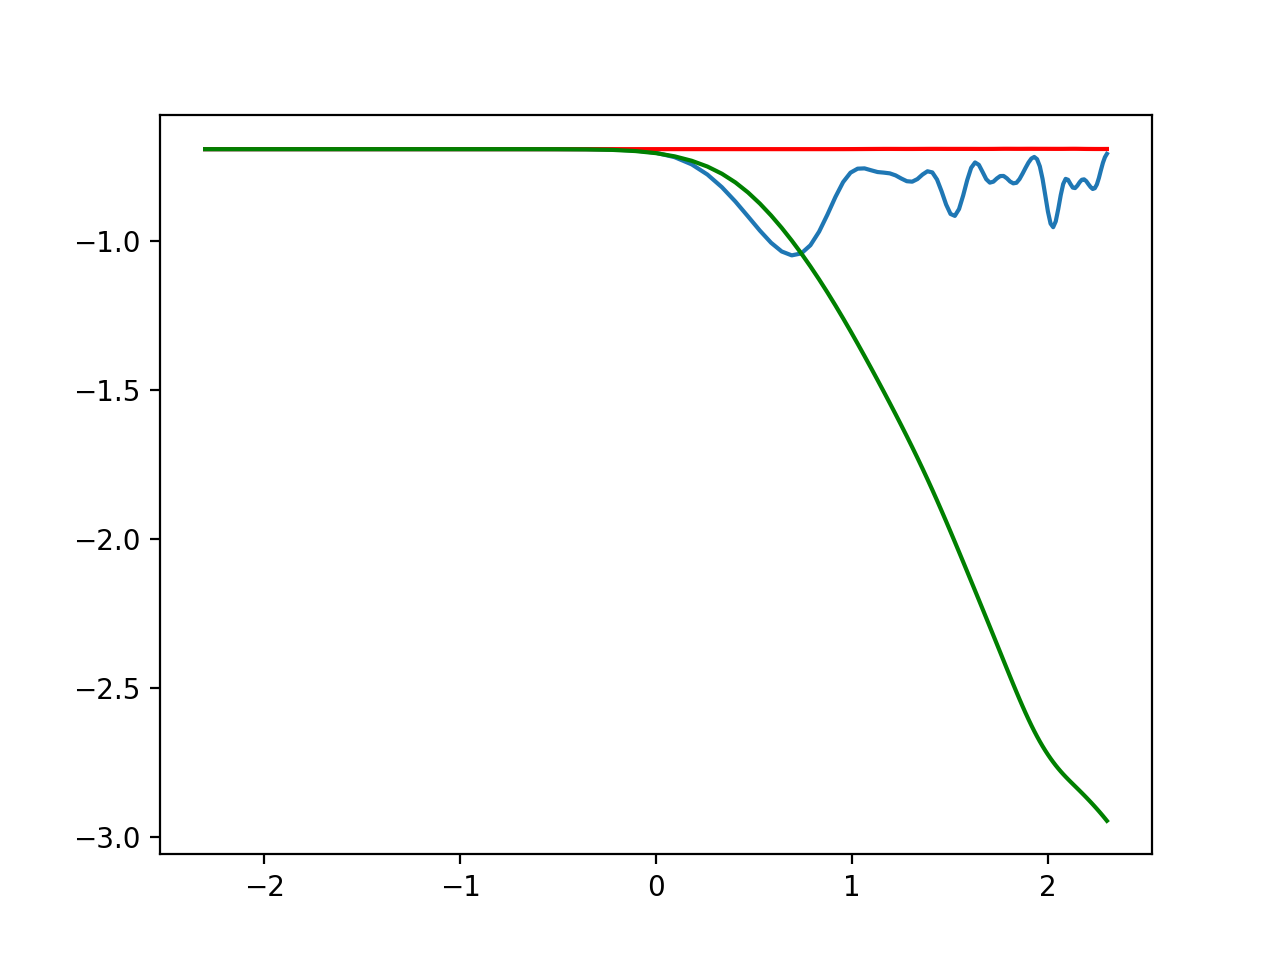

<IPython.core.display.Javascript object>


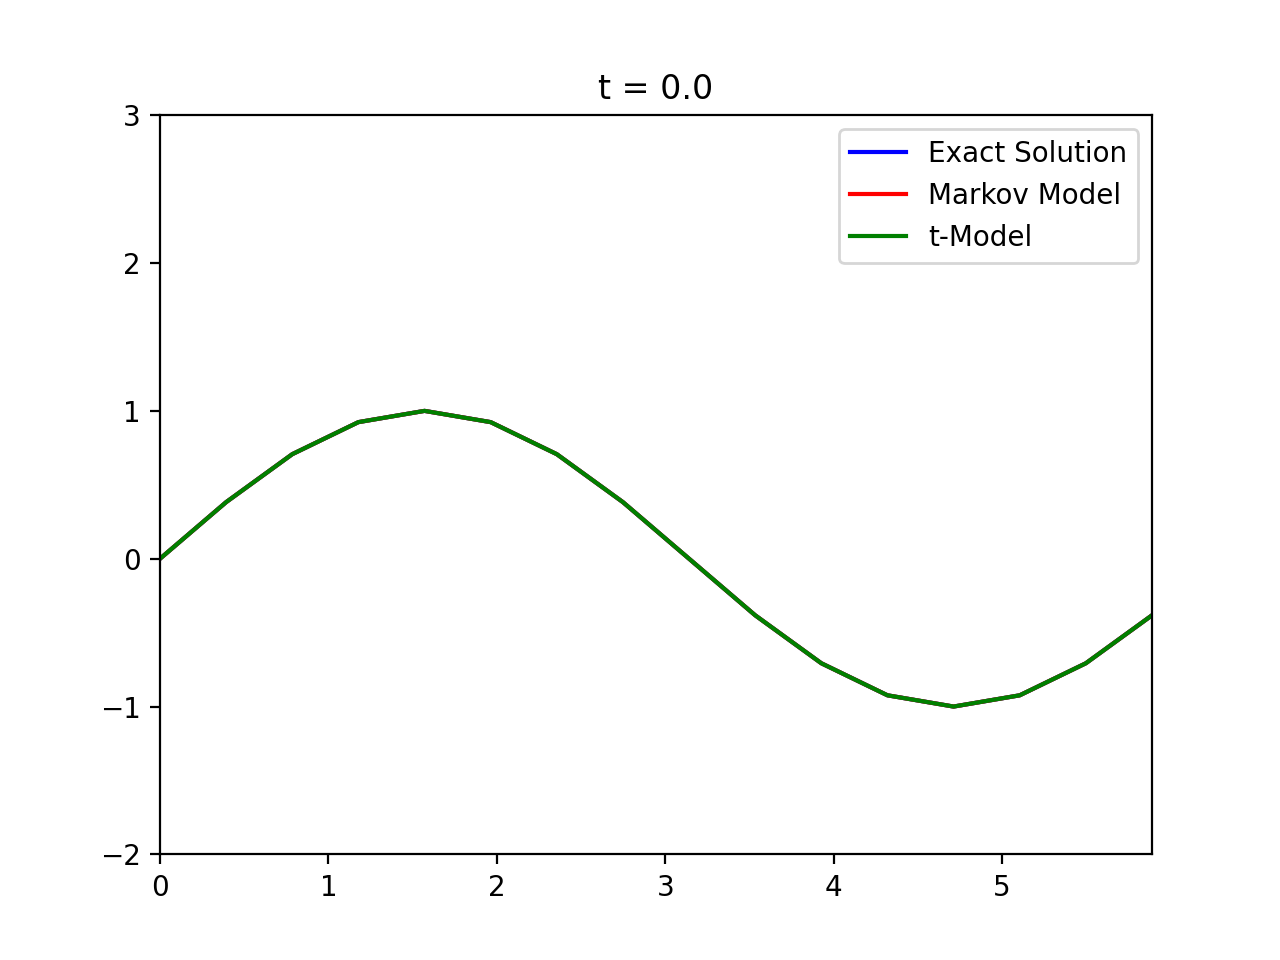

In [4]:
# test of Markov and Full models with animation

fullN = 64
reducedN = 8

uSimFull = MZKdV.nonRenormSim(N = fullN,endtime = 10, timesteps = np.arange(0,10.1,0.1))
uFull = uSimFull.y
t = uSimFull.t

uSimMarkov = MZKdV.markovSim(N = reducedN,endtime = 10, timesteps = np.arange(0,10.1,0.1))
uMarkov = uSimMarkov.y

uSimtModel = MZKdV.tModelSim(N = reducedN,endtime = 10, timesteps = np.arange(0,10.1,0.1))
utModel = uSimtModel.y

plt.figure()
plt.plot(np.log(t[1:]),np.log(MZKdV.getMass(uFull[:,1:],reducedN)))
plt.plot(np.log(t[1:]),np.log(MZKdV.getMass(uMarkov[:,1:],reducedN)), color = "red")
plt.plot(np.log(t[1:]),np.log(MZKdV.getMass(utModel[:,1:],reducedN)), color = "green")
anim = MZKdV.makeAnimationtModel(uFull,uMarkov,utModel,t)

<IPython.core.display.Javascript object>


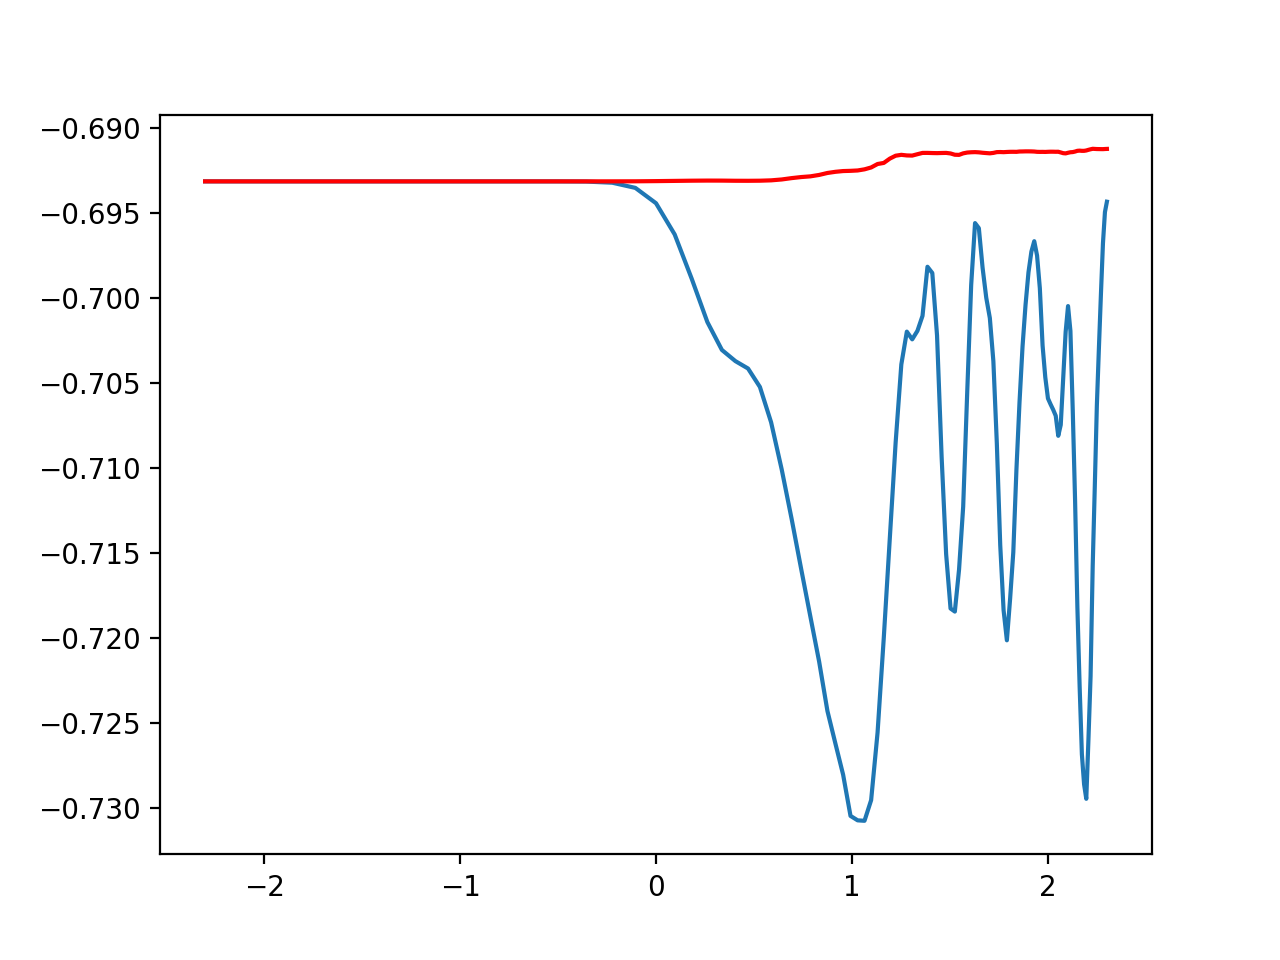

<IPython.core.display.Javascript object>


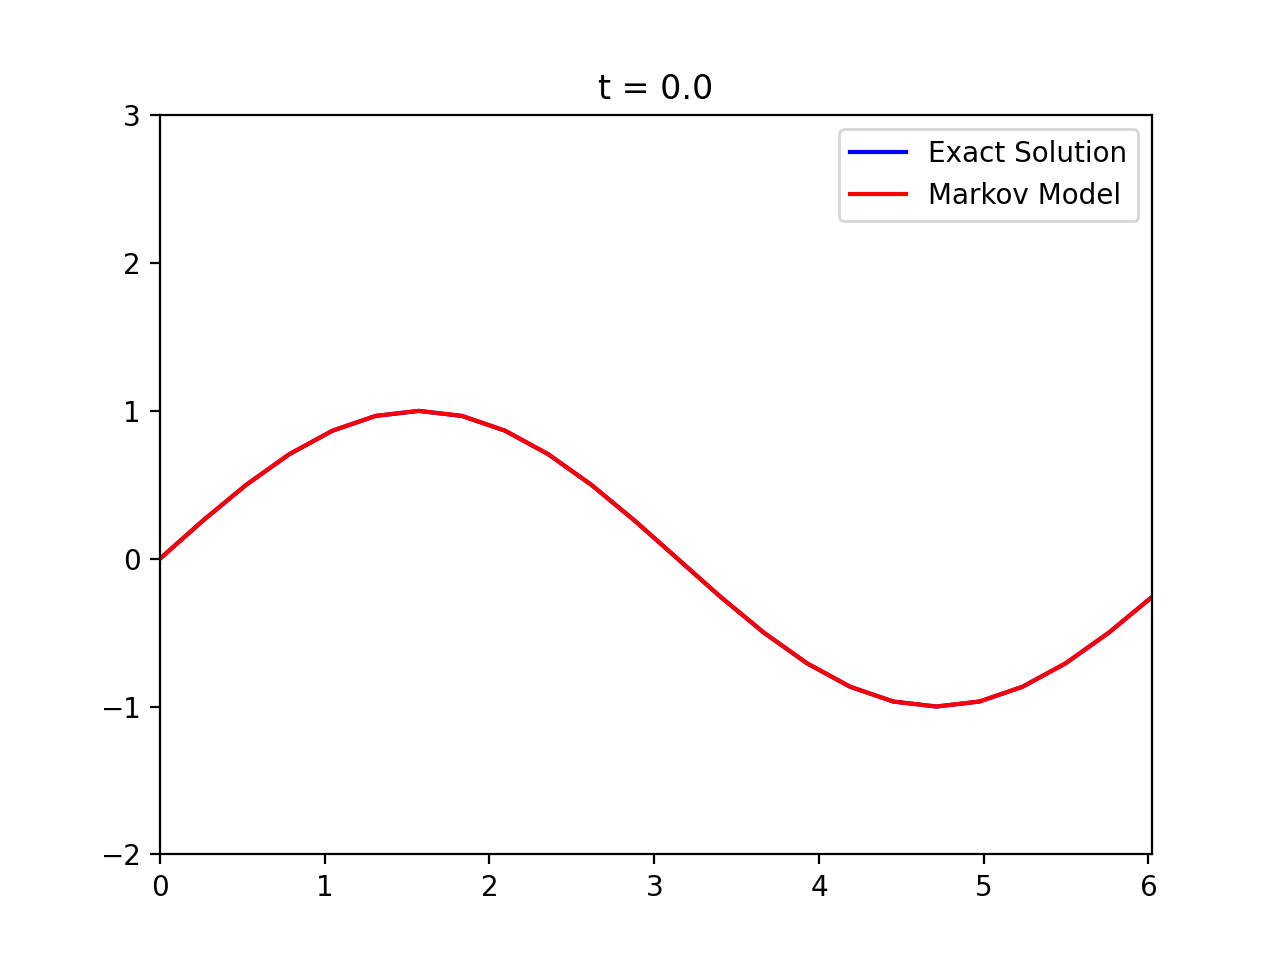

In [2]:
# test of Markov and Full models with animationb

fullN = 32
reducedN = 12

uSimFull = MZKdV.nonRenormSim(N = fullN,endtime = 10, timesteps = np.arange(0,10.1,0.1))
uFull = uSimFull.y
t = uSimFull.t

uSimMarkov = MZKdV.markovSim(N = reducedN,endtime = 10, timesteps = np.arange(0,10.1,0.1))
uMarkov = uSimMarkov.y

plt.figure()
plt.plot(np.log(t[1:]),np.log(MZKdV.getMass(uFull[:,1:],reducedN)))
plt.plot(np.log(t[1:]),np.log(MZKdV.getMass(uMarkov[:,1:],reducedN)), color = "red")
anim = MZKdV.makeAnimationFullMarkov(uFull,uMarkov,t)

In [4]:
N = 8
alpha = 1
epsilon = 0.1
t = 2

M = 3*N

F_modes = np.concatenate([np.arange(0,N),np.arange(2*N-1,4*N+2),np.arange(5*N+1,6*N)])

x = np.linspace(0,2*np.pi-2*np.pi/(2*N),2*N)
y = x
uFull = MZKdV.fftnorm(y)
u = uFull[0:N]

out = MZKdV.RHStModelKdV(u,N,3*N,alpha,epsilon,2)

k = np.arange(0,N)

nonlin0,u_full = MZKdV.markovKdV(u,M,alpha)
nonlin1,uuStar = MZKdV.tModelKdV(u_full,nonlin0,alpha,F_modes)


#print(nonlin0[0:N])
#print(nonlin1[0:N])

print(nonlin0[0:N]+nonlin1[0:N]*t)

[ 0.         +0.j          3.36374548 -1.71642931j
  4.72818616 -3.51713149j  7.94927424 -6.2761785j
 13.69051939 -9.06414233j 23.10593713-11.25646746j
 39.47025067-12.28400973j 78.2758726 -11.36179234j]


In [8]:
N = 20
alpha = 1
epsilon = 0.1

x = np.linspace(0,2*np.pi-2*np.pi/(2*N),2*N)
y = np.sin(x)
uFull = MZKdV.fftnorm(y)
u = uFull[0:N]

print(MZKdV.RHSMarkovKdV(u,N,3*N,alpha,epsilon))
print(MZKdV.RHStModelKdV(u,N,3*N,alpha,epsilon,0))

[ 0.00000000e+00+0.00000000e+00j  5.00000000e-03-1.75832052e-18j
  2.58636515e-17+2.50000000e-01j -2.76937268e-17+1.03566667e-17j
 -2.05422559e-17+6.90014024e-17j  1.63404204e-17-5.11652967e-17j
  4.09597992e-17-1.03431066e-17j  2.70537667e-17-1.63072864e-17j
  9.82863251e-17+3.51945677e-17j  9.18670200e-17+7.24281832e-17j
  5.53477169e-17+5.04358960e-17j  9.27522163e-17+8.17862636e-17j
 -1.74931936e-17-6.54418482e-17j  2.88390014e-16+3.05798375e-16j
  9.58576246e-17+5.05809157e-16j -1.41359320e-15+2.11424112e-16j
 -8.52040463e-17-4.67285277e-16j  2.31292006e-16-2.59205001e-16j
  2.16681561e-16+4.13752353e-16j  8.27989816e-16+8.55787971e-16j]
[ 0.00000000e+00+0.00000000e+00j  5.00000000e-03-5.44094319e-19j
  1.57752284e-18+1.83446534e-19j  8.02828188e-18+1.09068141e-18j
  5.52868481e-18+5.63700555e-18j -1.75845070e-19-1.30252122e-17j
  1.87553388e-17-1.03431066e-17j  0.00000000e+00-2.95416712e-17j
  2.94235537e-17+2.20034055e-17j  4.81087531e-17+6.02663300e-17j
  4.85722573e-17+8.61273

In [2]:
N = 8
alpha = 1

x = np.linspace(0,2*np.pi-2*np.pi/(2*N),2*N)
y = np.sin(x)
uFull = MZKdV.fftnorm(y)
u = uFull[0:N]

F_modes = np.concatenate([np.arange(0,N),np.arange(2*N-1,4*N+2),np.arange(5*N+1,6*N)])

nonlin0,u_full = MZKdV.markovKdV(u,3*N,alpha)

MZKdV.tModelKdV(uFull,nonlin0,alpha,F_modes)

(16,)
(48,)


NameError: u and v must be the same length.

In [7]:
N = 8
M = 3*N

np.arange(N+1,2*M-N+1)

array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
       26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40])

In [11]:
np.concatenate([np.arange(0,M-1),np.arange(-2*M,-1)])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22, -48, -47, -46,
       -45, -44, -43, -42, -41, -40, -39, -38, -37, -36, -35, -34, -33,
       -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20,
       -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,
        -6,  -5,  -4,  -3,  -2])

In [10]:
np.arange(0,M-1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])